# Predict future latency using LTSM
Haytham Mohamed - INFS890 - Spring 2020

In [51]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import sys

print(sys.executable)

%matplotlib inline

/opt/anaconda3/envs/infs890/bin/python


In [52]:
input_dir = '/Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/'

#input_file = 'raw_timeseries_data.csv'
input_file = 'no_outliers_dataset.csv'

output_dir = input_dir + 'models/'
model_checkpoint_file='lstm_model_checkpoint.keras'

log_dir = output_dir + 'models/model_logs/'


target = 'svc_ltcy_200'

RUN_LSTM = True

SCALE_TARGET = False
SCALE_FEATURES = True

# training window steps
# train with n number of minutes worth of sequence. 
# note: each observation is scrapped every 15 seconds
# every 4 oberservations are for a minute time window
# 1 minute = 4 observations
# 1 hour = 1 * 60 * 4 observations  .. and so on
training_window = 1 * 60 * 4

# prediction steps
# again 1 observation is scrapped every 15 seconds
# predicting a 5 minutes ahead, is equivalent to skipping 5 * 4 observations
prediction_minutes =  5

shift_steps = prediction_minutes * 4


In [53]:
metrics_df = pd.read_csv(input_dir + input_file)
metrics_df.head(3)

,date,svc_resp_size,svc_cpu_use,svc_req_rate,system_net_use,svc_pods,svc_net_use,system_cpu_use,svc_ltcy_200,svc_disk_use,svc_req_size
0,2020-02-27 22:49:50,20.460420,2.166677,1.29,2.579341,7.0,-0.571974,2.77,0.96,5.032348,1.921885
1,2020-02-27 22:50:35,40.236221,-6.739642,3.56,3.694395,7.0,2.534885,3.18,3.93,2.163715,5.850586
2,2020-02-27 22:50:50,38.784131,1.954651,3.38,3.636447,7.0,-0.661786,3.39,4.00,26.683041,5.593096


In [54]:
metrics_df.shape

(2318, 11)

In [55]:
# move target column to the end 
cols = metrics_df.columns.tolist()
cols.insert(len(cols)-1, cols.pop(cols.index(target)))
metrics_df = metrics_df.reindex(columns= cols)

# index by date and sort
metrics_df.date = pd.to_datetime(metrics_df.date)
metrics_df.set_index('date', inplace=True)
metrics_df.sort_index()

metrics_df.head(3)

,svc_resp_size,svc_cpu_use,svc_req_rate,system_net_use,svc_pods,svc_net_use,system_cpu_use,svc_disk_use,svc_req_size,svc_ltcy_200
date,,,,,,,,,,
2020-02-27 22:49:50,20.460420,2.166677,1.29,2.579341,7.0,-0.571974,2.77,5.032348,1.921885,0.96
2020-02-27 22:50:35,40.236221,-6.739642,3.56,3.694395,7.0,2.534885,3.18,2.163715,5.850586,3.93
2020-02-27 22:50:50,38.784131,1.954651,3.38,3.636447,7.0,-0.661786,3.39,26.683041,5.593096,4.00


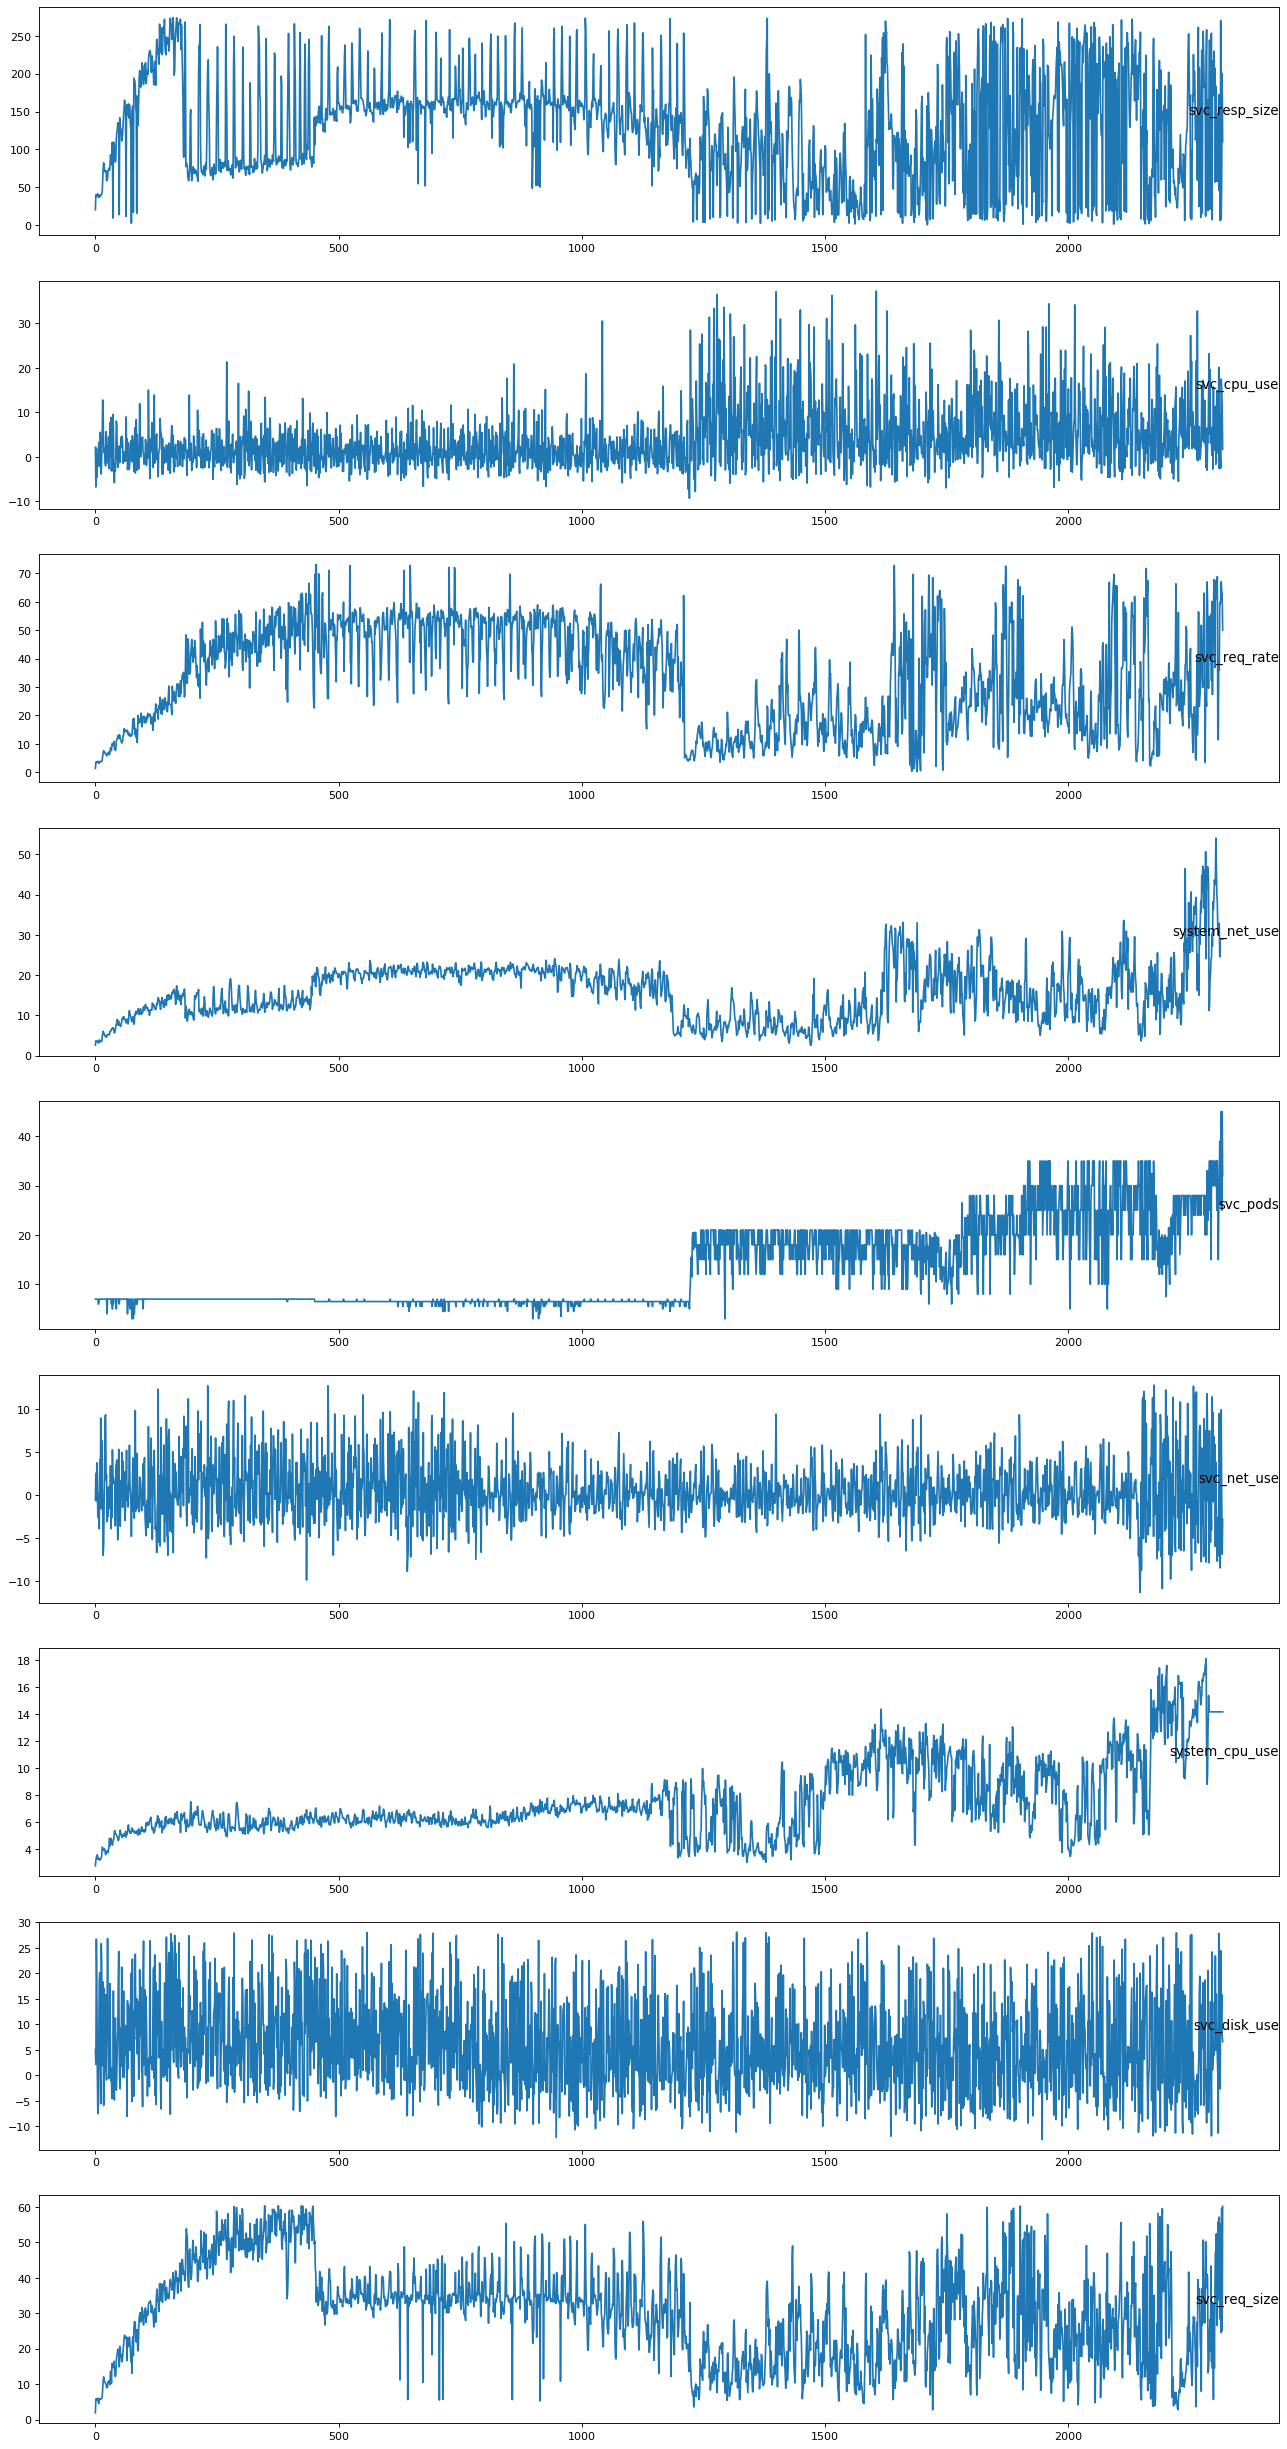

In [56]:
values = metrics_df.values
columns = metrics_df.columns

# specify columns to plot
number_of_features = len(columns) - 1

i = 1
## plot each column
plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')
for group in range(number_of_features):
    plt.subplot(number_of_features, 1, i)
    plt.plot(values[:, group])
    plt.title(columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# Shift target Data for Prediction

Assuming a 1 minute ahead prediction.

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation every 1 second, so there are 60 observations for every minute.

If we want to predict the latency 1 minute into the future, we shift the data 4 time-steps. If we want to predict the weather 2 minutes into the future, we shift the data 2 * 60 time-steps, and so on

In [57]:
# Target data series
df_targets = metrics_df[target].shift(-shift_steps)
df_targets.head(5)

date
2020-02-27 22:49:50    2.16
2020-02-27 22:50:35    4.56
2020-02-27 22:50:50    4.78
2020-02-27 22:51:05    8.33
2020-02-27 22:51:20    8.53
Name: svc_ltcy_200, dtype: float64

In [58]:
# double checking the shifted data
metrics_df[target].head(shift_steps + 5)  # before shifting. Note the 5th record shifted first

date
2020-02-27 22:49:50    0.96
2020-02-27 22:50:35    3.93
2020-02-27 22:50:50    4.00
2020-02-27 22:51:05    3.98
2020-02-27 22:51:20    0.44
2020-02-27 22:51:35    0.43
2020-02-27 22:51:50    4.32
2020-02-27 22:52:05    4.50
2020-02-27 22:52:20    4.34
2020-02-27 22:52:50    0.43
2020-02-27 22:53:05    0.43
2020-02-27 22:53:20    1.64
2020-02-27 22:53:50    1.68
2020-02-27 22:54:05    0.43
2020-02-27 22:54:35    3.20
2020-02-27 22:54:50    2.16
2020-02-27 22:55:05    1.22
2020-02-27 22:55:20    1.96
2020-02-27 22:55:35    2.05
2020-02-27 22:55:50    3.61
2020-02-27 22:56:05    2.16
2020-02-27 22:56:20    4.56
2020-02-27 22:56:35    4.78
2020-02-27 22:57:05    8.33
2020-02-27 22:57:20    8.53
Name: svc_ltcy_200, dtype: float64

In [59]:
df_targets.tail()  # note last recrods are shifted up and no more values on them

date
2020-02-28 17:49:50   NaN
2020-02-28 17:50:50   NaN
2020-02-28 17:54:35   NaN
2020-02-28 18:28:20   NaN
2020-02-28 18:29:50   NaN
Name: svc_ltcy_200, dtype: float64

# Data as Numpy Arrays

In [60]:
x_data = metrics_df[0:-shift_steps]
x_data = x_data.values
print("Shape x_data: ", x_data.shape)
print("type x_data: ", type(x_data))

y_data = df_targets.values[:-shift_steps]
y_data = y_data.reshape(-1,1)
print("Shape y_data: ", y_data.shape)
print("type y_data: ", type(y_data))

num_data = len(x_data)
print("There are {} sample data".format(num_data))

Shape x_data:  (2298, 10)
type x_data:  <class 'numpy.ndarray'>
Shape y_data:  (2298, 1)
type y_data:  <class 'numpy.ndarray'>
There are 2298 sample data


In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if SCALE_FEATURES:
    x_scaler = MinMaxScaler()  # StandardScaler()
    x_data = x_scaler.fit_transform(x_data)

In [62]:
if SCALE_TARGET:
    y_scaler =  MinMaxScaler() # StandardScaler()
    y_data = y_scaler.fit_transform(y_data)

In [63]:
from numpy import hstack

dataset = hstack((x_data, y_data))
dataset[1]

array([0.144926  , 0.05494524, 0.04724733, 0.02375171, 0.125     ,
       0.57430412, 0.02672751, 0.36256501, 0.06728736, 0.39239239,
       4.56      ])

In [64]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [65]:
x_dataset, y_dataset = split_sequences(dataset, training_window)

print("x_dataset shape {} and y_dataset shape {}".format(x_dataset.shape,y_dataset.shape))

x_dataset shape (2059, 240, 10) and y_dataset shape (2059,)


In [66]:
validate_split = 0.1
test_split = 0.1
train_split = 1 - (test_split + validate_split)

num_test = int(test_split * num_data)
num_validate = int(validate_split * num_data)
num_train = num_data - (num_test + num_validate)
print('Data splitted to training {} , validation {} and testing {}'.format(num_train, num_validate, num_test))

Data splitted to training 1840 , validation 229 and testing 229


In [67]:
x_train = x_dataset[:num_train]
x_validate = x_dataset[num_train:num_train+num_validate]
x_test = x_dataset[num_train+num_validate:]

print("x_train {} , x_validate {} , x_test {}".format(x_train.shape, x_validate.shape, x_test.shape))

len(x_train) + len(x_validate) + len(x_test)

x_train (1840, 240, 10) , x_validate (219, 240, 10) , x_test (0, 240, 10)


2059

In [68]:
y_train = y_dataset[:num_train]
y_validate = y_dataset[num_train:num_train+num_validate]
y_test = y_dataset[num_train+num_validate:]

print("y_train {} , y_validate {} , y_test {}".format(y_train.shape, y_validate.shape, y_test.shape))

len(y_train) + len(y_validate) + len(y_test)

y_train (1840,) , y_validate (219,) , y_test (0,)


2059

In [69]:
print('y_test shape {}'.format(y_test.shape))
y_test[0:10]

y_test shape (0,)


array([], dtype=float64)

In [70]:
num_x_signals = x_dataset.shape[2]
num_x_signals

num_y_signals = y_data.shape[1]
num_y_signals

print('Experiment has {} number of features and {} number of target(s)'.format(num_x_signals,num_y_signals))


Experiment has 10 number of features and 1 number of target(s)


## Multivariate LSTM Forecast Model

We need to model a forecasting model that can predict set of metrics given past observed metrics. I will fit an LSTM model to the collected metrics data. 

Instead of training the Recurrent Neural Network on the complete sequences of all observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [71]:
def batch_generator(batch_size, sequence_length=training_window):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        #y_shape = (batch_size, sequence_length, num_y_signals)
        #y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        y_batch = []

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx]
            y_batch.append(y_train[idx])
        
        yield (x_batch, np.array(y_batch))

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of sequence_length below.

In [72]:
batch_size = 300

create the batch-generator.

In [73]:
generator = batch_generator(batch_size)

We can then test the batch-generator to see if it works.

In [74]:
x_batch, y_batch = next(generator)

This gives us a random batch of 246, each batch has 240 observations, and each observation has 13 input-signals and 1 output-signals.

In [75]:
print(x_batch.shape)
print(y_batch.shape)

(300, 240, 10)
(300,)


We can plot one of the 20 input-signals as an example.

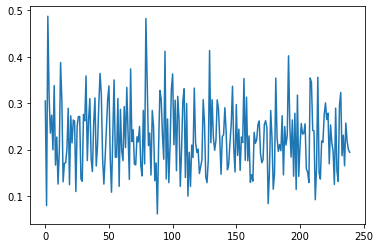

In [76]:
batch = 0   # First sequence in the batch.
signal = 1  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

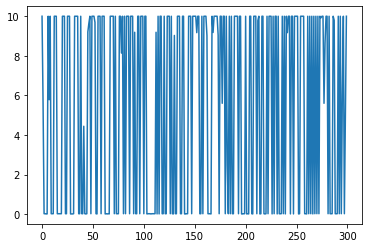

In [77]:
seq = y_batch
plt.plot(seq)

# Validation and Testing Data

For the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [78]:
test_data = (x_test, y_test)
validate_data = (x_validate, y_validate)

# -----------------------------------------------

# LTSM Model


We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [79]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [80]:
warmup_steps = 50

In [81]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:warmup_steps]
    y_pred_slice = y_pred[:warmup_steps]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

Next, define and fit an LSTM model.

I will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 14 features.

In [82]:
hidden_nodes_number_1 = 30
hidden_nodes_number_2 = 15
hidden_nodes_number_3 = 8

initialize=False

# design network
model = Sequential()


if initialize:
    from tensorflow.python.keras.initializers import RandomUniform
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, input_shape=(None, num_x_signals,)))
    #model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, return_sequences=True, activation='relu'))
    model.add(Dense(hidden_nodes_number_2, kernel_initializer=init, activation='relu'))
    model.add(Dense(hidden_nodes_number_3, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
else:
    model.add(LSTM(hidden_nodes_number_1, kernel_initializer='normal', input_shape=(None, num_x_signals,)))
    #model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, return_sequences=True, activation='relu'))
    model.add(Dense(hidden_nodes_number_2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(hidden_nodes_number_3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mean_squared_error', optimizer='adam')

#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
#model.compile(loss='mse', optimizer=optimizer)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                4920      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 5,522
Trainable params: 5,522
Non-trainable params: 0
_________________________________________________________________



# Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [83]:
path_checkpoint = output_dir + model_checkpoint_file
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [84]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [85]:
callback_tensorboard = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [86]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [87]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Train the Model

In [88]:
%%time
epochs = 20
batch_size = 1000

steps_per_epoch = int(num_train / batch_size)   # = total number of training data points divided by the batch size

if RUN_LSTM:
    history = model.fit_generator(generator=generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validate_data,
                    callbacks=callbacks, verbose=1, shuffle=False)

Epoch 1/20
Epoch 1/20
219/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00002: val_loss improved from 89.06816 to 89.04303, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 950ms/step - loss: 44.7375 - val_loss: 89.0430
Epoch 3/20
Epoch 1/20
219/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00004: val_loss improved from 89.01738 to 88.99093, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 956ms/step - loss: 59.4018 - val_loss: 88.9909
Epoch 5/20
Epoch 1/20
219/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00006: val_loss improved from 88.96353 to 88.93504, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 938ms/step - loss: 41.3500 - val_loss: 88.9350
Epoch 7/20
Epoch 1/20
219/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00008: val_loss improved from 88.90492 to 88.87300, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 965ms/step - loss: 69.4355 - val_loss: 88.8730
Epoch 9/20
Epoch 1/20
219/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00010: val_loss improved from 88.83869 to 88.80161, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 969ms/step - loss: 52.9077 - val_loss: 88.8016
Epoch 11/20
Epoch 1/20
219/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00012: val_loss improved from 88.76138 to 88.71756, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 958ms/step - loss: 42.5576 - val_loss: 88.7176
Epoch 13/20
Epoch 1/20
219/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00014: val_loss improved from 88.66956 to 88.61707, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 940ms/step - loss: 56.9185 - val_loss: 88.6171
Epoch 15/20
Epoch 1/20
219/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00016: val_loss improved from 88.55960 to 88.49679, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 942ms/step - loss: 53.6157 - val_loss: 88.4968
Epoch 17/20
Epoch 1/20
219/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00018: val_loss improved from 88.42833 to 88.35450, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 924ms/step - loss: 60.9591 - val_loss: 88.3545
Epoch 19/20
Epoch 1/20
219/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Epoch 00020: val_loss improved from 88.27441 to 88.18789, saving model to /Users/hmohamed/github/data-research-spring2020/raw-data-linode-run3-rules/models/lstm_model_checkpoint.keras
1/1 [==============================] - 1s 965ms/step - loss: 54.2861 - val_loss: 88.1879
CPU times: user 1min 24s, sys: 56.2 s, total: 2min 20s
Wall time: 23.9 s


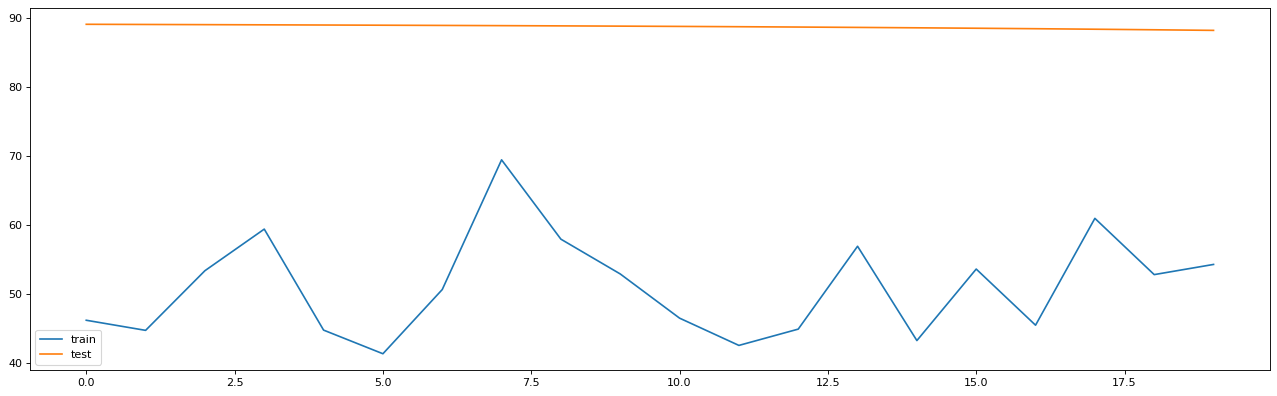

In [89]:
# plot history
if RUN_LSTM:
    plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

# Evaluate the Model

In [90]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [91]:
result = model.evaluate(x=x_test, y=y_test)


ValueError: Empty training data.

In [ ]:

print("loss (test-set):", result)

In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

# Plot Prediction

In [ ]:
def y_comparison(start_idx, length=100, target_scaled=True, data_set='train'):
    """
    Obtain predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if data_set == 'train':
        # Use training-data.
        x = x_train
        y_true = y_train
    elif data_set == 'validate':
        x = x_validate
        y_true = y_validate
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    #x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    if target_scaled:
        # The output of the model is scaled.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        y_pred = y_scaler.inverse_transform(y_pred)
    
    print("shape y_pred: %", y_pred.shape)
    print("shape y_true: %", y_true.shape)
    
    return y_true, y_pred


#This helper-function plots the predicted and true output-signals.
def plot_comparison(signal_true, signal_pred):
    """
    Plot the predicted and true output-signals.
    """

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('ltcy')
    plt.legend()
    plt.show()

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [ ]:
train_signal_true, train_signal_pred = y_comparison(start_idx=10, length=1000
                                                    , target_scaled=SCALE_TARGET, data_set='train')
plot_comparison(train_signal_true, train_signal_pred)

In [ ]:
train_signal_pred.reshape(-1,1000)

print('shape y test {}'.format(train_signal_true.shape))
print('shape y predicted {}'.format(train_signal_pred.shape))

#print ("Actual train values: \n {}".format(train_signal_true[:20]))
#print ("Predicted train values: \n {}".format(train_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_signal_true, train_signal_pred))
print('Train RMSE: %.3f' % rmse)

In [ ]:
plt.scatter(train_signal_true, train_signal_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

## Evaluate Model

In [ ]:
test_signal_true, test_signal_pred = y_comparison(start_idx=10, length=1000
                                                    , target_scaled=SCALE_TARGET, data_set='test')
plot_comparison(test_signal_true, test_signal_pred)

In [ ]:
print('shape y test {}'.format(test_signal_true.shape))
print('shape y predicted {}'.format(test_signal_pred.shape))

#print ("Actual test values: \n {}".format(test_signal_true[:20]))
#print ("Predicted test values: \n {}".format(test_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_signal_true, test_signal_pred))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.scatter(test_signal_true, test_signal_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [ ]:
# df['f'] = df['d'].rolling(2).sum().shift(-1)

print(test_signal_true.shape)
print(test_signal_pred.shape)

true_df = round(pd.DataFrame(test_signal_true, columns=['actual']),2)
pred_df = round(pd.DataFrame(test_signal_pred, columns=['predicted']),2)


compare_df = pd.concat([true_df,pred_df], axis=1, sort=False)

# testing mean_absolute_percentage_error
compare_df['residual'] = round(compare_df['actual'] - compare_df['predicted'], 2)
compare_df['difference%'] = round(np.absolute(compare_df['residual']* 100 / compare_df['actual']),2)

compare_df.head(5)

In [ ]:
compare_df.describe()

In [ ]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
compare_df.sort_values(by = ['difference%'])

R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [ ]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(test_signal_true)
sum_squared_residual = np.sum(np.power(compare_df['residual'] , 2))
sum_squared_variance = np.sum(np.power(test_signal_true - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared